**Name:** YANG Yongze

**EID:** 58162280

**Kaggle Team Name:** YANG Yongze

# CS5489 - Assignment 1 - SMS Classification

## Final submission
In this file, put the code that generates your final Kaggle submission. It will be used to verify that your Kaggle submission is reproducible.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
random.seed(100)

In [2]:
def read_text_data(fname):
    txtdata = []
    classes = []
    with open(fname, 'r', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in reader:
            # get the text
            txtdata.append(row[0])
            # get the class (convert to integer)
            if len(row)>1:
                classes.append(int(row[1]))
        
    return (txtdata, classes)

def write_csv_kaggle_sub(fname, Y):
    # fname = file name
    # Y is a list/array with class entries
    
    # header
    tmp = [['Id', 'Prediction']]
    
    # add ID numbers for each Y
    for (i,y) in enumerate(Y):
        tmp2 = [(i+1), y]
        tmp.append(tmp2)
        
    # write CSV file
    with open(fname, 'w') as f:
        writer = csv.writer(f)
        writer.writerows(tmp)

In [3]:
# load the data
(traintxt, trainY) = read_text_data("smishing_train.txt")
(testtxt, _)       = read_text_data("smishing_test.txt")

print(len(traintxt))
print(len(testtxt))

2985
2986


In [4]:
import collections

print(collections.Counter(trainY))

Counter({0: 2454, 2: 297, 1: 234})


Obviously, the train data is imbalanced data.

## Data Prepossessing
We can do some data prepossessing steps as below:
1. Delete non-numeric and alphabetic characters.
2. Delete stop words. Remove words that do not contribute much to the meaning of the text.
3. Lemmatization. Converting words to their prototypes may reduce the number of features.
4. Convert into lower case. Treating both case words as the same word may reduce the number of features.

In [7]:
from nltk.corpus import stopwords
from nltk import word_tokenize, PorterStemmer, SnowballStemmer, WordNetLemmatizer
import re
import nltk

# Init stop words and stemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(str):
    """
    Preprocess text data by removing non-alphanumeric characters & stop word and lemmatizing

    :param str: input string
    :return: preprocessed string
    """

    # Remove non-alphanumeric characters
    string_only_alphanumeric = re.sub(r'[^a-zA-Z0-9]', ' ', str)
    # Tokenize the string into individual words
    words = word_tokenize(string_only_alphanumeric)
    new_str = ''

    for word in words:
        if not word.isdigit():
            # Remove stop word
            if word not in stop_words:
                # lemmatization and convert to lower case
                stemmed_word = lemmatizer.lemmatize(word)
                lower_word = stemmed_word.lower()
                if new_str == '':
                    new_str += lower_word
                else:
                    new_str = new_str + ' ' + lower_word
    return new_str

# test = 'En chikku nange bakra msg kalstiya..then had tea/coffee?'
# print(preprocess(test))

train_txt_preprocessed = [preprocess(s) for s in traintxt]
test_txt_preprocessed = [preprocess(s) for s in testtxt]
print('Preprocessing finished.')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yyz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yyz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yyz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\yyz\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Preprocessing finished.


## Feature Representation

### Using TF-IDF Model

Use Count Vectorizer to convert text into vectors by counting how often each word appears in the text. Subsequently, the TF-IDF value of each word is calculated.

After the above feature extraction, a portion of the data from the training set is divided and used to perform verification of accuracy.

In [8]:
# Count Vectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=700)
train_features = vectorizer.fit_transform(train_txt_preprocessed)
test_features = vectorizer.fit_transform(test_txt_preprocessed)

# Calculate TF-IDF value
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
trainX = tf_trans.fit_transform(train_features)
test_X = tf_trans.transform(test_features)

# Split validation data
X_train, X_valid, y_train, y_valid = train_test_split(trainX, trainY, stratify=trainY, test_size=0.65, random_state=0)


What if we try something new representation form?
### Using Word2Vec
**Word2Vec** \[1\] may be a good choice for word embedding. But first, we need to slightly modify the preprocess function to get a word list instead of a string.

\[1\] Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient Estimation of Word Representations in Vector Space. arXiv preprint arXiv:1301.3781.

In [46]:
def preprocess_list(str):
    """
    Preprocess text data by removing non-alphanumeric characters & stop word and lemmatizing

    :param str: input string
    :return: preprocessed word list
    """

    # Remove non-alphanumeric characters
    string_only_alphanumeric = re.sub(r'[^a-zA-Z0-9]', ' ', str)
    # Tokenize the string into individual words
    words = word_tokenize(string_only_alphanumeric)
    new_str = []

    for word in words:
        if not word.isdigit():
            # Remove stop word
            if word not in stop_words:
                # lemmatization and convert to lower case
                stemmed_word = lemmatizer.lemmatize(word)
                lower_word = stemmed_word.lower()
                new_str.append(lower_word)
    return new_str

test = 'En chikku nange bakra msg kalstiya..then had tea/coffee?'
print(preprocess_list(test))

['en', 'chikku', 'nange', 'bakra', 'msg', 'kalstiya', 'tea', 'coffee']


Next, use Grid Search to select the best parameters using BernoulliNB's balanced accuracy score as the basis of evaluation

In [49]:
from sklearn.model_selection import ParameterGrid
from gensim.models import Word2Vec

train_word_list = [preprocess_list(s) for s in traintxt]

param_grid = {
    'vector_size': [50, 75, 100, 125, 150, 200, 500],
    'window': [2, 3, 4, 5, 7, 10],
    'min_count': [1, 2, 3]
}
best_score = 0
best_params = None

model_bnb_w2v = naive_bayes.BernoulliNB(alpha=1e-10)

# Grid Search for Parameters
for params in ParameterGrid(param_grid):
    model_w2v = Word2Vec(train_word_list, **params)
    X = []
    # Build word2Vec features
    for sentence in train_word_list:
        sentence_vector = []
        for word in sentence:
            # if the word is in the wv list
            if word in model_w2v.wv:
                word_vec = model_w2v.wv[word]
                sentence_vector.append(word_vec)
        if len(sentence_vector) > 0:
            # can be presented as a vector
            average_vec = np.mean(sentence_vector,axis=0)
        else:
            # vector of 0 as default
            average_vec = np.zeros(params['vector_size'])
        X.append(average_vec)

    # Split data
    X_train, X_valid, y_train, y_valid = train_test_split(X, trainY, stratify=trainY, test_size=0.7, random_state=0)

    # USe bnb to train and predict
    model_bnb_w2v.fit(X_train,y_train)
    y_pred_bnb = model_bnb_w2v.predict(X_valid)

    score = metrics.balanced_accuracy_score(y_valid, y_pred_bnb)

    # Get the best balanced accuracy score
    if score > best_score:
        best_score = score
        best_params = params

print(f'Best score: {best_score}')
print(f'Best params: {best_params}')

Best score: 0.5590510221391279
Best params: {'min_count': 1, 'vector_size': 500, 'window': 4}


The result does not look good. I think this may due to the following reasons:

1. SMS text is relatively short, some SMS text may only contain small amount of words. Therefore, the Word2Vec may not be good at capturing the meaning of the content.
2. Some SMS text contain misspelled words, unusual words and some abbreviations. These words might be ignored when using Word2Vec to generate vectors.
3. When generating vectors, some information might be lost.

Therefore, using TF-IDF might be a better choice.


## Training
Next, use **Multinomial Naive Bayes Classifier**, **Multinomial Naive Bayes Classifier**, **One-vs-Rest Classifier**, **Random Forest Classifier**, **Support Vector Machine Classifier**, **Logistic Regression Classifier**, **K Nearest Neighbours Classifier**, **Decision Trees Classifier** and other machine learning methods for training and prediction, and the *BALANCED ACCURACY* of the predicted values is verified using a previously divided validation set.
This step is only used to do preliminary comparisons, and the parameters are used by default wherever possible.

In [112]:
# Multinomial Naive Bayes Classifier
model_mnb = naive_bayes.MultinomialNB(alpha=0.001)
model_mnb.fit(X_train,y_train)
y_pred_mnb = model_mnb.predict(X_valid)
acc_mnb = metrics.balanced_accuracy_score(y_valid,y_pred_mnb)
print('[MNB] Balanced_accuracy_score:', acc_mnb)

# Bernoulli Naive Bayes Classifier
model_bnb = naive_bayes.BernoulliNB(alpha=0.001)
model_bnb.fit(X_train,y_train)
y_pred_bnb = model_bnb.predict(X_valid)
acc_bnb = metrics.balanced_accuracy_score(y_valid,y_pred_bnb)
print('[BNB] Balanced_accuracy_score:', acc_bnb)

# One Vs Rest Classifier
model_ovr = multiclass.OneVsRestClassifier(ensemble.GradientBoostingClassifier())
model_ovr.fit(X_train,y_train)
y_pred_ovr = model_ovr.predict(X_valid)
acc_ovr = metrics.balanced_accuracy_score(y_valid,y_pred_ovr)
print('[OVR] Balanced_accuracy_score:', acc_ovr)

# Random Forest Classifier
model_rf = ensemble.RandomForestClassifier()
model_rf.fit(X_train,y_train)
y_pred_rf = model_rf.predict(X_valid)
acc_rf = metrics.balanced_accuracy_score(y_valid,y_pred_rf)
print('[RF] Balanced_accuracy_score:', acc_rf)

# Support Vector Machine Classifier
model_svm = svm.SVC(class_weight='balanced')
model_svm.fit(X_train,y_train)
y_pred_svm = model_svm.predict(X_valid)
acc_svm = metrics.balanced_accuracy_score(y_valid,y_pred_svm)
print('[SVM] Balanced_accuracy_score:', acc_svm)

# Logistic Regression Classifier
model_lr = linear_model.LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_valid)
acc_lr = metrics.balanced_accuracy_score(y_valid, y_pred_lr)
print('[LR] Balanced_accuracy_score:', acc_lr)

# K Neighbors Classifier
model_knn = neighbors.KNeighborsClassifier()
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_valid)
acc_knn = metrics.balanced_accuracy_score(y_valid, y_pred_knn)
print('[KNN] Balanced_accuracy_score:', acc_knn)

# Decision Tree Classifier
model_dt = tree.DecisionTreeClassifier()
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_valid)
acc_dt = metrics.balanced_accuracy_score(y_valid, y_pred_dt)
print('[DT] Balanced_accuracy_score:', acc_dt)

[MNB] Balanced_accuracy_score: 0.689300972638851
[BNB] Balanced_accuracy_score: 0.7962755550361221
[OVR] Balanced_accuracy_score: 0.6739252059336597
[RF] Balanced_accuracy_score: 0.7357150432211791
[SVM] Balanced_accuracy_score: 0.7686584769349972
[LR] Balanced_accuracy_score: 0.3387716917509664
[KNN] Balanced_accuracy_score: 0.4144671912942979
[DT] Balanced_accuracy_score: 0.7362777626276399


- According to the results, Bernoulli Simple Bayes has the best classification and is higher than Polynomial Simple Bayes. This may be due to the fact that the features are independent of each other and the distribution is more in line with the Bernoulli distribution.

- Also, the Support Vector Machine result looks good. I think the SVM is a robust classifier and is suitable for text classification tasks. It can handle imbalanced data.

- Logistic Regression Classifier and K Neighbors Classifier perform relatively worst. This may be due to the poor ability of these algorithms for text processing and the high dimensionality of textual data features that do not satisfy linear separability.


## Using Bernoulli Naive Bayes Classifier
Therefore, it is a good idea to use Bernoulli's plain Bayesian classifier. Next try to search for the best parameters.

### Find the best alpha value

What is the best `alpha` value?

In [113]:
alphas = logspace(-2,1,100)
balanced_accuracy_scores = []
for alpha in alphas:
    # Bernoulli Naive Bayes Classifier
    model_bnb = naive_bayes.BernoulliNB(alpha=alpha)
    model_bnb.fit(X_train,y_train)
    y_pred_bnb = model_bnb.predict(X_valid)
    acc_bnb = metrics.balanced_accuracy_score(y_valid,y_pred_bnb)
    balanced_accuracy_scores.append(acc_bnb)
max_index = argmax(balanced_accuracy_scores)
best_baccuracy_score = balanced_accuracy_scores[max_index]
best_alpha = alphas[max_index]

print('[BNB] Best Balanced_accuracy_score:', best_baccuracy_score)
print('[BNB] Best alpha:', alphas[max_index])


[BNB] Best Balanced_accuracy_score: 0.8094734894230395
[BNB] Best alpha: 0.1


Now we know the best `alpha` is 0.1. The figure of `alpha` vs Balanced Accuracy Score is shown below.

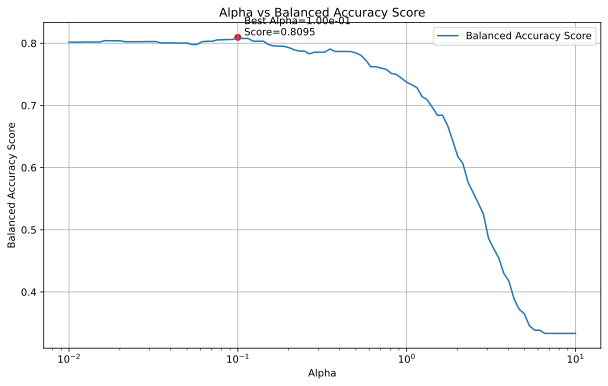

In [114]:
plt.figure(figsize=(10, 6))
plt.semilogx(alphas, balanced_accuracy_scores, label='Balanced Accuracy Score')
plt.scatter(best_alpha, best_baccuracy_score, color='red')
plt.text(best_alpha, best_baccuracy_score, f'  Best Alpha={best_alpha:.2e}\n  Score={best_baccuracy_score:.4f}', verticalalignment='bottom')
plt.xlabel('Alpha')
plt.ylabel('Balanced Accuracy Score')
plt.title('Alpha vs Balanced Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()

### Find the best max_feature value
How do `max_feature` influences the balanced accuracy result?

In [115]:
max_features = arange(100,5000,10)
baccuracy_scores = []
for max_feature in max_features:
    # Count Vectorizer
    vectorizer = CountVectorizer(stop_words='english', max_features=max_feature)
    train_features = vectorizer.fit_transform(train_txt_preprocessed)
    test_features = vectorizer.fit_transform(test_txt_preprocessed)

    # Calculate TF-IDF value
    tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
    trainX = tf_trans.fit_transform(train_features)
    test_X = tf_trans.transform(test_features)

    # Split validation data
    X_train, X_valid, y_train, y_valid = train_test_split(trainX, trainY, stratify=trainY, test_size=0.65, random_state=0)

    # Bernoulli Naive Bayes Classifier
    model_bnb = naive_bayes.BernoulliNB(alpha=0.1)
    model_bnb.fit(X_train,y_train)
    y_pred_bnb = model_bnb.predict(X_valid)
    acc_bnb = metrics.balanced_accuracy_score(y_valid,y_pred_bnb)
    baccuracy_scores.append(acc_bnb)
max_index = argmax(baccuracy_scores)
best_baccuracy_score = baccuracy_scores[max_index]
best_max_feature = max_features[max_index]

print('[BNB] Best Balanced_accuracy_score:', best_baccuracy_score)
print('[BNB] Best max_features:', best_max_feature)

[BNB] Best Balanced_accuracy_score: 0.825170114405184
[BNB] Best max_features: 3150


Now we know the best `max_feature` is 3150. The figure of Max_features vs Balanced Accuracy Score is shown below.

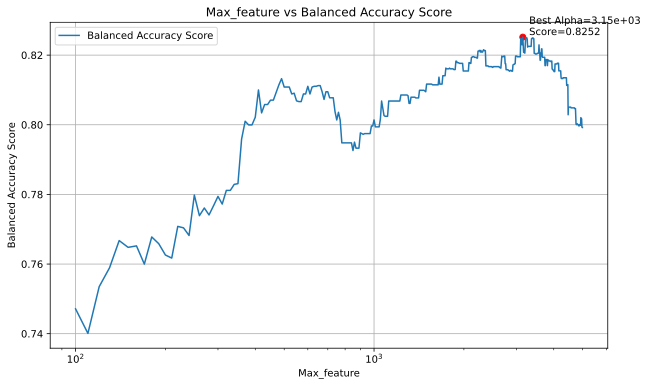

In [116]:
plt.figure(figsize=(10, 6))
plt.semilogx(max_features, baccuracy_scores, label='Balanced Accuracy Score')
plt.scatter(best_max_feature, best_baccuracy_score, color='red')
plt.text(best_max_feature, best_baccuracy_score, f'  Best Alpha={best_max_feature:.2e}\n  Score={best_baccuracy_score:.4f}', verticalalignment='bottom')
plt.xlabel('Max_feature')
plt.ylabel('Balanced Accuracy Score')
plt.title('Max_feature vs Balanced Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()

Therefore, we can train model and predict the test data using the best `alpha` and the best `max_feature`.

In [5]:
train_txt_preprocessed = [preprocess(s) for s in traintxt]
test_txt_preprocessed = [preprocess(s) for s in testtxt]

# Count Vectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=3150)
train_features = vectorizer.fit_transform(train_txt_preprocessed)
test_features = vectorizer.transform(test_txt_preprocessed)

# Calculate TF-IDF value
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_X = tf_trans.fit_transform(train_features)
test_X = tf_trans.transform(test_features)

# Train BernoulliNB
model_bnb = naive_bayes.BernoulliNB(alpha=0.1)
model_bnb.fit(train_X,trainY)
y_pred_bnb = model_bnb.predict(test_X)

Make the submission csv and look at some sample of the predicted result.

In [7]:
write_csv_kaggle_sub("my_submission.csv", y_pred_bnb)
classnames = unique(trainY)
classlabels = ['normal', 'spam', 'smishing']
for c in classnames:
    tmp = where(trainY==c)
    for a in tmp[0][0:10]:
        print('[{}]: {}'.format(classlabels[trainY[a]], traintxt[a]))

[normal]: Dunno da next show aft 6 is 850. Toa payoh got 650.
[normal]: I.ll hand her my phone to chat wit u
[normal]: I dont have i shall buy one dear
[normal]: Nite...
[normal]: Ok�congrats�
[normal]: Oops I did have it,  &lt;#&gt; ?
[normal]: Yeah. I got a list with only u and Joanna if I'm feeling really anti social
[normal]: Message from . I am at Truro Hospital on ext. You can phone me here. as I have a phone by my side
[normal]: Y ü wan to go there? C doctor?
[normal]: Not from this campus. Are you in the library?
[spam]: I'd like to tell you my deepest darkest fantasies. Call me 09094646631 just 60p/min. To stop texts call 08712460324 (nat rate)
[spam]: Santa Calling! Would your little ones like a call from Santa Xmas eve? Call 09058094583 to book your time.
[spam]: Meet Top 35 US universities in Delhi at India Habitat Centre Lodhi Road on Nov 8th, 2 to 6 pm for student admission.Entry Free,  details contact 9911489000
[spam]: SMS AUCTION You have won a Nokia 7250i. This is wha

According to the kaggle result, the balanced accuracy score is 0.85972.


## Using Support Vector Machine

We know that the data is imbalanced data and SVM is good for predicting imbalanced data.

For SVMs, we can try different `C`, `gamma` value.
We can use GridSearchCV to get the best value.


In [36]:
train_txt_preprocessed = [preprocess(s) for s in traintxt]
test_txt_preprocessed = [preprocess(s) for s in testtxt]

# Count Vectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=3150)
train_features = vectorizer.fit_transform(train_txt_preprocessed)
test_features = vectorizer.transform(test_txt_preprocessed)

# Calculate TF-IDF value
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_X = tf_trans.fit_transform(train_features)
test_X = tf_trans.transform(test_features)

param_grid = {'C': np.logspace(-3,2,10), 'gamma': np.logspace(-3,1,10)}

model_svm = svm.SVC(class_weight='balanced')

grid = model_selection.GridSearchCV(model_svm, param_grid, refit=True, verbose=0, scoring='balanced_accuracy')

grid.fit(train_X,trainY)

print("Best params: ", grid.best_params_)
print("Best balanced accuracy: ", grid.best_score_)


Best params:  {'C': 2.1544346900318843, 'gamma': 0.46415888336127775}
Best balanced accuracy:  0.8636871226380242


Now that we know the best parameter set is {'C': 2.1544346900318843, 'gamma': 0.46415888336127775}.
We can validate that:

In [29]:
model_svm = svm.SVC(class_weight='balanced', C=2.1544346900318843, gamma=0.46415888336127775)

X_train, X_valid, y_train, y_valid = train_test_split(train_X, trainY, stratify=trainY, test_size=0.6, random_state=0)

model_svm.fit(X_train,y_train)
y_pred_svm = model_svm.predict(X_valid)
acc_svm = metrics.balanced_accuracy_score(y_valid,y_pred_svm)
print('[SVM] Balanced_accuracy_score:', acc_svm)


[SVM] Balanced_accuracy_score: 0.8225607211236173


We can see that the result is good, but not as good as the Bernoulli Naive Bayes model.

Let's see some of the incorrectly predicted result.

In [35]:
incorrect_indices_svm = np.where(y_valid!=y_pred_svm)[0]

X_train_txt, X_valid_txt, _, _ = train_test_split(traintxt, trainY, stratify=trainY, test_size=0.6, random_state=0)
i=0
for index in incorrect_indices_svm:
    if i>=10:
        break
    print(f"True label: {y_valid[index]}, Predicted label: {y_pred_svm[index]} \nCorresponding x: {X_train_txt[index]}")
    i = i +1

True label: 0, Predicted label: 1 
Corresponding x: Thts god's gift for birds as humans hav some natural gift frm god..
True label: 0, Predicted label: 1 
Corresponding x: 	our mobile number has won £5000, to claim calls us back or ring the claims hot line on 09050005321.
True label: 0, Predicted label: 1 
Corresponding x: No it's waiting in e car dat's bored wat. Cos wait outside got nothing 2 do. At home can do my stuff or watch tv wat.
True label: 0, Predicted label: 1 
Corresponding x: Are you willing to go for apps class.
True label: 1, Predicted label: 0 
Corresponding x: Urgent! call 09066350750 from your landline. Your complimentary 4* Ibiza Holiday or 10,000 cash await collection SAE T&Cs PO BOX 434 SK3 8WP 150 ppm 18+ 
True label: 2, Predicted label: 1 
Corresponding x: The wine is flowing and i'm i have nevering..
True label: 0, Predicted label: 1 
Corresponding x: Dont gimme that lip caveboy
True label: 0, Predicted label: 1 
Corresponding x: U don't remember that old comme

I think that the main reason of mis-prediction is that the training set is too small and imbalanced, and some noice may exist in training data which may influence the accuracy score.

Then try train an SVC using full training set and make a Kaggle submission.

In [25]:
train_txt_preprocessed = [preprocess(s) for s in traintxt]
test_txt_preprocessed = [preprocess(s) for s in testtxt]

# Count Vectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=3150)
train_features = vectorizer.fit_transform(train_txt_preprocessed)
test_features = vectorizer.transform(test_txt_preprocessed)

# Calculate TF-IDF value
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_X = tf_trans.fit_transform(train_features)
test_X = tf_trans.transform(test_features)

model_svm = svm.SVC(class_weight='balanced', C=2.1544346900318843, gamma=0.46415888336127775)

model_svm.fit(train_X,trainY)
y_pred_svm = model_svm.predict(test_X)


In [26]:
write_csv_kaggle_sub("my_submission_svm.csv", y_pred_svm)
classnames = unique(trainY)
classlabels = ['normal', 'spam', 'smishing']
for c in classnames:
    tmp = where(trainY==c)
    for a in tmp[0][0:10]:
        print('[{}]: {}'.format(classlabels[trainY[a]], traintxt[a]))

[normal]: Dunno da next show aft 6 is 850. Toa payoh got 650.
[normal]: I.ll hand her my phone to chat wit u
[normal]: I dont have i shall buy one dear
[normal]: Nite...
[normal]: Ok�congrats�
[normal]: Oops I did have it,  &lt;#&gt; ?
[normal]: Yeah. I got a list with only u and Joanna if I'm feeling really anti social
[normal]: Message from . I am at Truro Hospital on ext. You can phone me here. as I have a phone by my side
[normal]: Y ü wan to go there? C doctor?
[normal]: Not from this campus. Are you in the library?
[spam]: I'd like to tell you my deepest darkest fantasies. Call me 09094646631 just 60p/min. To stop texts call 08712460324 (nat rate)
[spam]: Santa Calling! Would your little ones like a call from Santa Xmas eve? Call 09058094583 to book your time.
[spam]: Meet Top 35 US universities in Delhi at India Habitat Centre Lodhi Road on Nov 8th, 2 to 6 pm for student admission.Entry Free,  details contact 9911489000
[spam]: SMS AUCTION You have won a Nokia 7250i. This is wha

The kaggle result of is 0.84449, which is slightly smaller than Bernoulli Naive Bayes Classifier. I think this result does not accurately indicate which of the two algorithms is better, as they both give similar results and can be affected by randomness.